In [9]:
%load_ext autoreload
%autoreload 2

# import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import sys
from torchvision import datasets, transforms
from tqdm import tqdm
from scipy.spatial.distance import euclidean

# import the project root
sys.path.insert(0, '../..')
from src.covertree import CoverTree 
from src.dyadictree import DyadicTree, tree_traverse
from src.wavelettree import WaveletTree
from src.utils import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
def load_dataset(flatten=False):
    transform = transforms.Compose([
        transforms.ToTensor()
    ])

    cifar10_train = datasets.MNIST(root='../../datasets', train=True, download=True, transform=transform)
    X = np.stack([np.array(img[0].numpy()) for img in cifar10_train][:100])  # shape: (1000, 3, 32, 32)

    original_shape = X.shape
    if flatten:
        X = X.reshape(X.shape[0], -1)
    # print(X.shape)
    return X, original_shape    

X, original_shape = load_dataset(flatten=True)
p_n_points = X.shape[0]
print("X shape: %s" % str(X.shape))
print(p_n_points)


X shape: (100, 784)
100


In [15]:
from scipy.spatial.distance import euclidean
python_covertree =  CoverTree(X, euclidean, leafsize=1)
mydiadic_tree    =  DyadicTree(python_covertree)
wavelet_tree = WaveletTree(mydiadic_tree, X, 0, X.shape[-1], inverse=True,
                           thresholds=0) # inverse means data in (n,d) formatdj

info: computing basis and wavelets for dyadic tree of height 6
info: this may take time..
info: making wavelet tree
info: making wavelets
info: making transforms at level 5
info: making transforms at level 4
info: making transforms at level 3
info: making transforms at level 2
info: making transforms at level 1
info: making transforms at level 0


In [16]:
gmra_q_coeff = wavelet_tree.fgwt(X)
X_recon      = wavelet_tree.igwt(gmra_q_coeff, X.shape).reshape(original_shape)
print("X_recon shape: %s" % str(X_recon.shape))

X_recon shape: (100, 1, 28, 28)


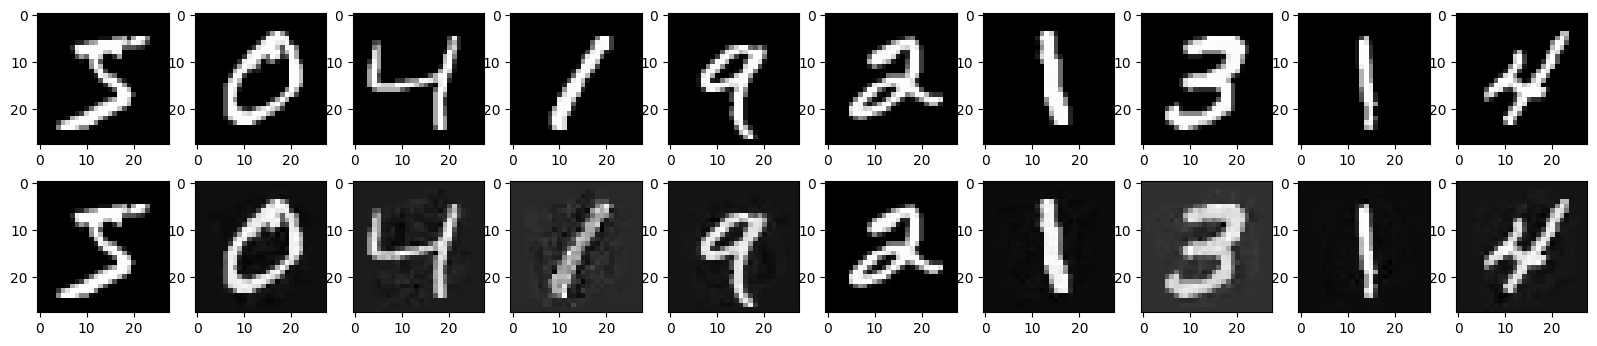

In [17]:
fig, ax = plt.subplots(2, 10, figsize=(20, 4))
for i in range(10):
    ax[0, i].imshow(X[i].reshape(28, 28), cmap='gray')
    ax[1, i].imshow(X_recon[i].reshape(28, 28), cmap='gray')
